In [1]:
%pip install pandas nltk
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    import nltk
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    import nltk
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    import nltk
    nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags symbols but keep the text
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove single character words
    tokens = [token for token in tokens if len(token) > 1]
    
    # Remove stopwords and lemmatize each token
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Ensure no empty string is returned
    cleaned_text = ' '.join(tokens)
    return cleaned_text if cleaned_text.strip() else "empty"

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

print(train[['id', 'text', 'clean_text']].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pvrch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   id                                               text  \
0   1  Our Deeds are the Reason of this #earthquake M...   
1   4             Forest fire near La Ronge Sask. Canada   
2   5  All residents asked to 'shelter in place' are ...   
3   6  13,000 people receive #wildfires evacuation or...   
4   7  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


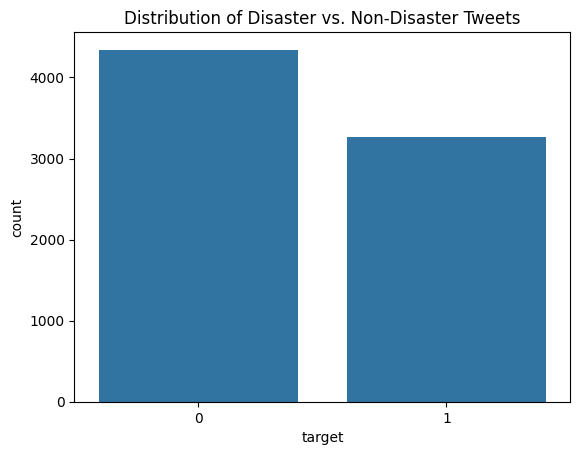

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=train["target"])
plt.title("Distribution of Disaster vs. Non-Disaster Tweets")
plt.show()


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF with bi-grams and tri-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Unigrams, Bigrams, Trigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(train['text'])
X_test_tfidf = tfidf_vectorizer.transform(test['text'])


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Create a stratified train-validation split
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_tfidf, train['target'], 
    test_size=0.2, 
    stratify=train['target'], 
    random_state=42
)



In [5]:
# Train Logistic Regression with updated TF-IDF features
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
log_model.fit(X_train_tfidf, train['target'])

# Train Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, train['target'])

# Predict
y_pred_lr = log_model.predict(X_test_tfidf)
y_pred_nb = nb_model.predict(X_test_tfidf)

# Predict on validation set
y_pred_lr_val = log_model.predict(X_val)
y_pred_nb_val = nb_model.predict(X_val)

# Evaluate on validation set
from sklearn.metrics import classification_report, f1_score

print("Logistic Regression F1 Score:", f1_score(y_val, y_pred_lr_val))
print(classification_report(y_val, y_pred_lr_val))

print("Naive Bayes F1 Score:", f1_score(y_val, y_pred_nb_val))
print(classification_report(y_val, y_pred_nb_val))



Logistic Regression F1 Score: 0.9356357927786499
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       869
           1       0.96      0.91      0.94       654

    accuracy                           0.95      1523
   macro avg       0.95      0.94      0.94      1523
weighted avg       0.95      0.95      0.95      1523

Naive Bayes F1 Score: 0.9432454036770583
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       869
           1       0.99      0.90      0.94       654

    accuracy                           0.95      1523
   macro avg       0.96      0.95      0.95      1523
weighted avg       0.96      0.95      0.95      1523



In [6]:
#Save the submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['target'] = y_pred_nb
submission.to_csv('submission.csv', index=False)
print(submission.head())

   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1
